## Summary

The following script gathers data from the YH finance API and stores it in an AWS MYSQL database for subsequent processing.
In this project I used Rapid API free tier and AWS free tier accounts for my testing. The YH finance api free tier allows for 500 queries per month which is why I have decided to keep the stock list small; however it should scale regardless of size as 
long as the amount of data does not exceed what I have been allocated through AWS which is around 20Gb. My goal was to create a simple data pipeline and present the user with a few financial indicators that may provide some insight as to how a certain asset has performed, is performing, and give an educated guess as to where it may go from the present time.

## Table of Contents
* [Imports & Constants](#Imports_&_Constants)
    * [Import Libs](#Import_Libs)
    * [Constants](#Constants)
* [Fetch Data](#Fetch_Data)
    * [Database Connection](#Database_Connection)
* [Financial Indicators](#Financial_Indicators)
    * [Plot daily Price/Volume change](#Plot_daily_Price/Volume_change)
    * [Plot 20, 50, 200 day Moving Average (MA)](#Plot_20,_50,_200_day_Moving_Average_(MA))
    * [Daily Average Return](#Daily_Average_Return)
    * [Bollinger Bands](#Bollinger_Bands)
    * [Correlation Plots](#Correlation_Plots)
* [Conclusion](#Conclusion)


## Imports & Constants <a class="anchor" id="Imports_&_Constants"></a>

### Import Libs <a class="anchor" id="Import_Libs"></a>

In [1]:
import config
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy
from sqlalchemy import MetaData
import requests
import missingno as msno
from matplotlib import rc_context
from matplotlib import ticker as tick
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from scipy import stats
import datetime as dt
import time
from datetime import date
sns.set(style="darkgrid")
import warnings
warnings.simplefilter("ignore")

### Constants <a class="anchor" id="Constants"></a>

The fetch_yh_api() method will currently retrieve 5 years of data from todays date. The S_DATE & E_DATE values will be used
in subsequent steps to window data for plotting purposes. These can be adjusted later and the cell can be re-ran without having any adverse effects on the AWS database. ENG_CONFIG was created simply to enhance readability where used in
the script.

In [2]:
S_DATE = '2017-04-19'
E_DATE = '2022-04-19'
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)
ENG_CONFIG = f"mysql://{config.DB_USER}:{config.DB_PASS}@{config.DB_HOST}:{config.DB_PORT}/{config.DB_NAME}"

## Fetch Data <a class="anchor" id="Fetch_Data"></a>

The method below makes the API call and stores the desired data as a .json file using the requests library. This dictionary allows the user to transform the .json file into a pandas dataframe that will serve as the primary data structure for the remainder of the project. For each label I have specified a data type that I thought would be appropriate in regards to the type of calculations that would be made later. The ticker symbol has been saved as a Categorical data type which should perform better on larger datasets. There is a config.py file in my project directory that has been generated to house my API info and the necessary information to access my AWS database. Any user will need their own to use this script, for privacy it has been added to my .gitignore file and will not be viewable on my repository. This function returns an organized pandas dataframe and we will have a quick peek at some basic attributes after instantiating our dataframe.

In [3]:
fetch_list = ['SPY','BABA','AMZN','AMC','TSLA']

In [4]:
def fetch_yh_api(tickers):
    
    try:
        url = "https://yh-finance.p.rapidapi.com/stock/v3/get-chart"

        headers = {
            'x-rapidapi-host': config.API_HOST,
            'x-rapidapi-key': config.API_KEY
            }

        df_temp = pd.DataFrame(columns=['Symbol','Date','Adj_Close','Close','Open','High','Low','Volume'])

        for i in tickers:
            querystring = {"interval":"1d","symbol":f"{i}","range":"5y","region":"US","includePrePost":"false",
                           "useYfid":"true","includeAdjustedClose":"true","events":"capitalGain,div,split"}
            response = requests.request("GET", url, headers=headers, params=querystring).json()
            
            time.sleep(1)
            print(f"Retrieving Data for {i} ...")
            for key in response['chart']['result']:
                symbol = key['meta']['symbol']
                date = key['timestamp']
                close = key['indicators']['quote'][0]['close']
                low = key['indicators']['quote'][0]['low']
                high = key['indicators']['quote'][0]['high']
                volume = key['indicators']['quote'][0]['volume']
                open_price = key['indicators']['quote'][0]['open']
                Adj_Close = key['indicators']['adjclose'][0]['adjclose']
                df_temp = df_temp.append({'Symbol':symbol,'Date':date,'Adj_Close':Adj_Close,'Close':close,
                                          'Open':open_price,'High':high,'Low':low,'Volume':volume}, ignore_index = True)

        df_temp = df_temp.apply(pd.Series.explode)
        df_temp['Date'] = pd.to_datetime(df_temp['Date'], unit='s').dt.normalize()
        df = df_temp.astype({'Symbol':'category','Adj_Close':'float64','Close':'float64','Open':'float64','High':'float64',
                             'Low':'float64','Volume':'int64'}) 
    
    except Exception as ex:
        print("Could not retrieve Data from: ", url, "!Check your J-son keys! or ticker Symbol")
    
    else:
        return df

In [5]:
df = fetch_yh_api(fetch_list)

Retrieving Data for SPY ...
Retrieving Data for BABA ...
Retrieving Data for AMZN ...
Retrieving Data for AMC ...
Retrieving Data for TSLA ...


### Database Connection <a class="anchor" id="Database_Connection"></a>

The following functions will permit the user to connect to a remote database, create a table, push/store the dataframe 
we created previously to that database, clear the database excluding the column labels, and query the database. The SQLAlchemy library provides us with the abilty to contact, store, manipulate, and retrieve the asset data we previously fetched from the API call. I am using another program called DBeaver to view all my changes quickly while working with my database. The connection object(con) is created first allowing for the use of the create_table method. Once a table is created attempting to re-run this method will throw an exception that the table has been created. A method clear_table has been provided for testing purposes which will clear the row values, but not the column labels. I attempted to write an SQL DROP query which did delete everything including the column labels; however, it completely broke my database on AWS and I had to recreate a new cloud database. I will investigate this in the future and try to provide a better way to do this, SO BE CAREFUL!! The final database method uses the con object to query our database based on ticker symbol and store the database in a pandas dataframe.

In [6]:
def connect_db():
    try:
        engine = sqlalchemy.create_engine(ENG_CONFIG)
        con = engine.connect()
        
    except Exception as ex:
        print("Could not establish a connection!!!")
        
    else:
        print('Connected!')
        return con

In [7]:
con = connect_db()

Connected!


In [ ]:
def create_table(con):
    create_table_command = '''
                            CREATE TABLE Yahoo (
                            Symbol varchar(20),
                            DATETIME DATE,
                            Adj_Close FLOAT,
                            Close FLOAT,
                            Open FLOAT,
                            High FLOAT,
                            Low FLOAT,
                            Volume FLOAT,
                            PRIMARY KEY (Symbol)
                            )'''
    con.execute(create_table_command)

In [8]:
def push_to_db(df):
    try:
        engine = sqlalchemy.create_engine(ENG_CONFIG)
        df.to_sql(f"{config.DB_NAME}", engine, if_exists='replace', index = False, chunksize=1000)
        
    except Exception as ex:
        print("Could not send data to DB, check your parameters.")


In [9]:
push_to_db(df)

In [ ]:
def clear_table(db_name):
    engine = sqlalchemy.create_engine(ENG_CONFIG)
    
    del_op = f'''DELETE FROM {db_name}''';
    
    with engine.connect() as con:
        result = con.execute(del_op)

    con.close()
    engine.dispose()

In [10]:
def ticker_query_db(ticker, con):
    engine = sqlalchemy.create_engine(ENG_CONFIG)
    sym_query = f'''SELECT *
                FROM Yahoo
                WHERE Symbol = '{ticker}';'''
    rows = con.execute(sym_query)
    ticker = pd.DataFrame(rows.fetchall())
    ticker.columns = [x for x in rows._metadata.keys]
    engine.dispose()
    
    return ticker

In [11]:
df_spy = ticker_query_db('SPY', con)
df_baba = ticker_query_db('BABA',con)
df_amc = ticker_query_db('AMC', con)
df_tsla = ticker_query_db('TSLA', con)

In [12]:
con.close()

## Financial Indicators <a class="anchor" id="Financial_Indicators"></a>

Up to this point we have retrieved our data via the YH finance API, reshaped it into a pandas dataframe, stored that dataframe in a MYSQL database on an AWS cloud server, and queried that remote database for assets that we would like to have a look at. These assets are now available to us as pandas dataframes. The first step below will be to have a look at some summary statistics for the desired asset and check the dataframe for missing values using the missongno library. The latter processing 
steps will be to visualize the performance of these stock to help aid a potential investor as to wether or not they should consider buying/selling them.

In [13]:
def get_summary_stats(df):
    pd.set_option('display.expand_frame_repr', False)
    print(df.info(),'\n')
    print(df.describe(),'\n')
    print(df.head())

In [14]:
get_summary_stats(df_amc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Symbol     1259 non-null   object        
 1   Date       1259 non-null   datetime64[ns]
 2   Adj_Close  1259 non-null   float64       
 3   Close      1259 non-null   float64       
 4   Open       1259 non-null   float64       
 5   High       1259 non-null   float64       
 6   Low        1259 non-null   float64       
 7   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 78.8+ KB
None 

         Adj_Close        Close         Open         High          Low        Volume
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean     14.608837    15.739428    15.775663    16.371009    15.183956  2.945549e+07
std      10.945375    11.057563    11.023031    11.722312    10.503917  7.840078

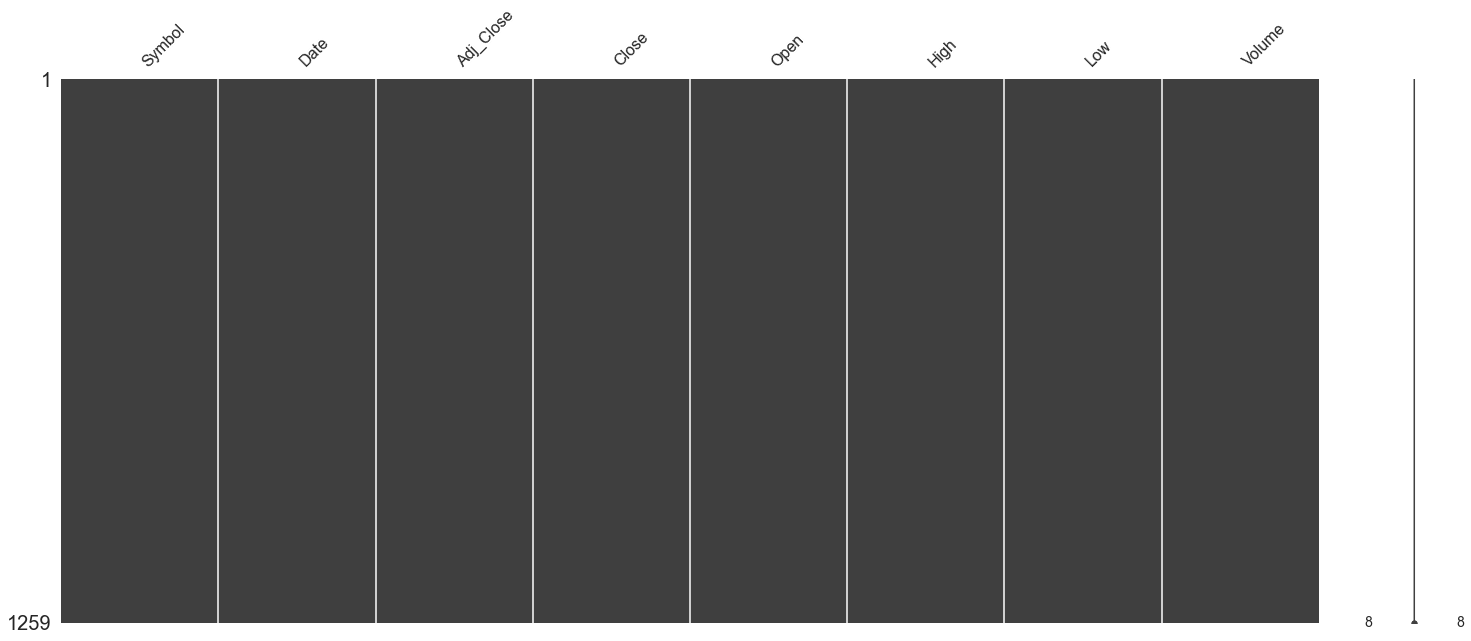

In [15]:
msno.matrix(df_amc)
plt.show()

### Plot daily Price/Volume change <a class="anchor" id="Plot_daily_Price/Volume_change"></a>

The relationship between the volume and price of a stock can either indicate that an investor should acquire or sell an assett. 
An increase in trading volume and price indicates that buying pressure from investor demand is increasing a stocks value. An increased trading voluming with falling prices may be a sign that the investor may consider selling. On average Volume is used as a market strength indicator, a higher volume and price over a period of time is viewed as a strong or helathier market. 

In [16]:
def price_vol_plot(df, name): 

    fig, ax1 = plt.subplots(sharex=True, sharey=True, figsize=(10, 6))

    ax1.grid(False)
    sns.lineplot(x= 'Date', y='Volume', data= df, ax= ax1, color= 'g', alpha=0.3, linewidth= .1)
    ax1.set_title(name + ' Price Vs Volume', fontsize= 16)
    ax1.fill_between(df['Date'].values,0,df['Volume'].values, color='g',alpha=0.3)
    ax1.set_ylim([0, ax1.get_ylim()[1] * 3])
    ax1.set_xlim([S_DATE_DT, E_DATE_DT])
    ax1.set_ylabel('Volume', fontsize=14, color='g', alpha=0.7)


    ax2 = ax1.twinx()

    sns.lineplot(x= 'Date', y='Adj_Close', data= df, ax= ax2, linewidth= .7, color= 'b',)
    ax2.set_ylabel('Price', fontsize=14, color='b', alpha=0.7)
    ax2.grid(True)

    plt.show()

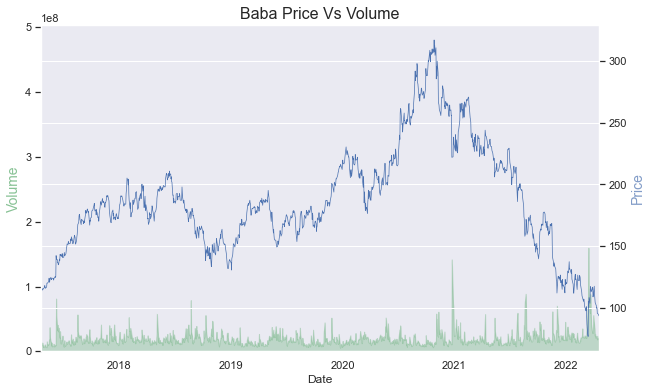

In [17]:
price_vol_plot(df_baba, 'Baba')

### Plot 20, 50, 200 day Moving Average (MA) <a class="anchor" id="Plot_20,_50,_200_day_Moving_Average_(MA)"></a>

The 200 day MA is a significant indicator used in trading. If the 50 day MA reamins above the 200 day MA and better yet the 20 day MA is above the 50 day MA, the stock is said to have a bullish trend. Generally speaking if the price of a stock is above a moving average it said said to be trending upward. The function below allows the user to calculate a Simple Moving Average(SMA)
or an Exponential Moving Average (EMA). The SMA simply calculates an average of price data, while the EMA applies more weight to data that is more current.

In [18]:
def mov_avg(df, *args, exp=False, name):
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    for idx, ma in enumerate(args):
        col = f"MA_{ma}" 
        if exp == True:
            df[col] = df['Adj_Close'].ewm(span=ma, adjust=False).mean()
        else:
            df[col] = df['Adj_Close'].rolling(window=ma, center=False).mean()     
        sns.lineplot(x='Date', y=f"MA_{args[idx]}", data=df, ax=ax1, label=str(ma), linewidth= .7)
    ax1.set_title(name + ' Moving Average', fontsize= 14)
    sns.lineplot(x='Date', y='Adj_Close', data=df, ax=ax1, linewidth= .7, linestyle='--')
    ax1.set_ylabel('Price', fontsize=14, color='b', alpha=0.7)
    ax1.set_xlim([S_DATE_DT, E_DATE_DT])
    plt.show()

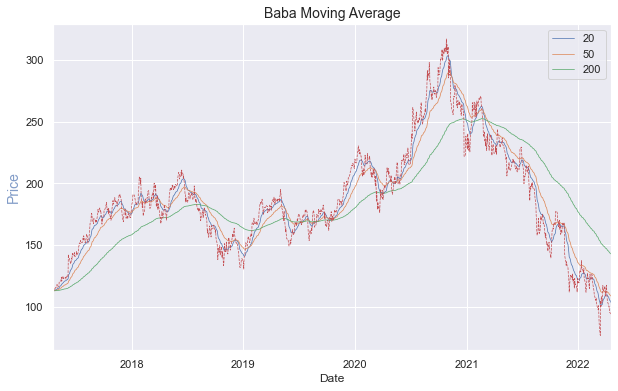

In [19]:
mov_avg(df_baba,20,50,200,exp= True,name="Baba")

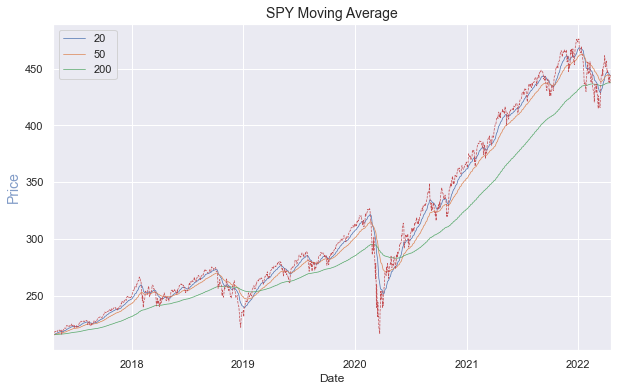

In [20]:
mov_avg(df_spy,20,50,200,exp= True,name="SPY")

### Daily Average Return <a class="anchor" id="Daily_Average_Return"></a>

The average return simply gives a simple visual representation of the stocks daily perofrmance per a given time
period. An asset with an average daily return above 0 over a period of years indicates growth and possibly a good
investment for a long term hold.

In [21]:
def avg_daily_ret(df):
    df['Daily_ret'] = df['Close'].pct_change()
    df['Pos/Neg'] = ''

    df.loc[(df['Daily_ret'] > 0), 'Pos/Neg'] = 'Above'
    df.loc[(df['Daily_ret'] < 0), 'Pos/Neg'] = 'Below'
    
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)

    df = df.astype({"Pos/Neg":'category'})
    
    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(131)
    g = sns.scatterplot(x="Date", y="Daily_ret", data=df, ax=ax1)
    ax1.set_title('% Change By Date', fontsize= 13)
    plt.xticks(rotation=45)

    ax2 = fig.add_subplot(132)
    g2 = sns.distplot(x=df.Daily_ret, color="red", vertical=True, ax=ax2)
    ax2.set_title('% Change KDE', fontsize= 13)
    
    ax3 = fig.add_subplot(133)
    ax3.set(yticklabels=[])
    ax3.set_title('Categorical +/-', fontsize= 13)
    
    g3 = sns.countplot(x='Pos/Neg', data=df, ax=ax3)
    g.axhline(y=0, color ="black", linestyle ="--")
    g2.axhline(y=0, color ="black", linestyle ="--")
    
    plt.show()

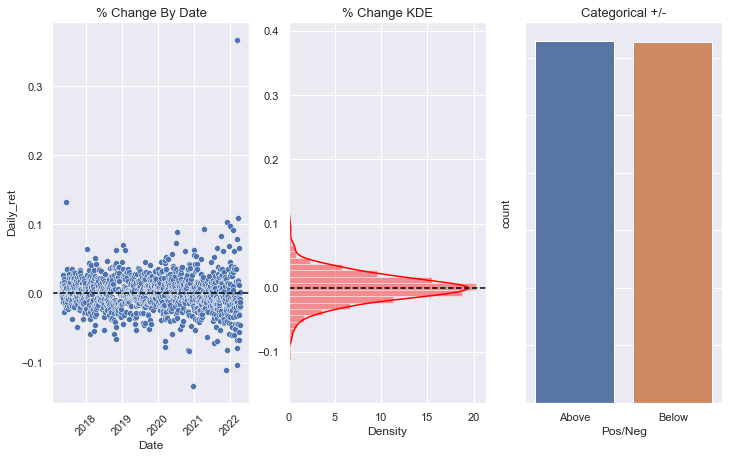

In [22]:
avg_daily_ret(df_baba)

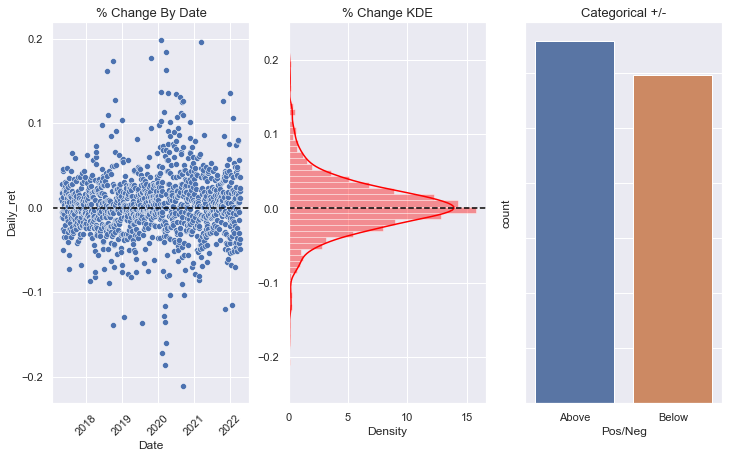

In [23]:
avg_daily_ret(df_tsla)

### Bollinger Bands <a class="anchor" id="Bollinger_Bands"></a>

Bollinger Bands are another very popular indicator used to assess a stocks performance. The main idea is that most stocks
will trend towards the average price trend. If the price is near the upper band it is considered expensive as it is reaching
in our case roughly 1.96 standard deviations above the average price. On the other hand if the asset is approaching the lower 
band (-1.96* STDEV) it is said to be cheap which is a good time to buy. Another advantage to using Bollinger bands is they expand when volatility is High and contract when volatility is Low. Periods of low volatility are often followed by periods of high volatility. This indicates an increase or decrease in value and this indicator along with others such as sentiment analysis may help create an accurate hypothesis in regards to where the price will go in the future.

In [24]:
def bollinger(df):

    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
    df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

    fig1, ax1 = plt.subplots(figsize=(12, 7))
    width = .5
    cola = 'green'
    colb = 'red'
    colc = 'blue'
    
    # Bands
    sns.lineplot(x='Date', y='middle_band', data=df, color= cola, size=0.1, ax=ax1, linestyle='--', alpha=.7)
    sns.lineplot(x='Date', y='upper_band', data=df, color= colc, size=0.1, ax=ax1, alpha=.3)
    sns.lineplot(x='Date', y='lower_band', data=df, color= colc, size=0.1, ax=ax1, alpha=.3)
    
    ohlc = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    #ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    
    candlestick_ohlc(ax1, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    
    ax1.get_legend().remove()
    ax1.set_xlim(S_DATE_DT, E_DATE_DT)
    plt.title("Bollinger Bands",fontsize=14)
    plt.ylabel('')
    plt.show()

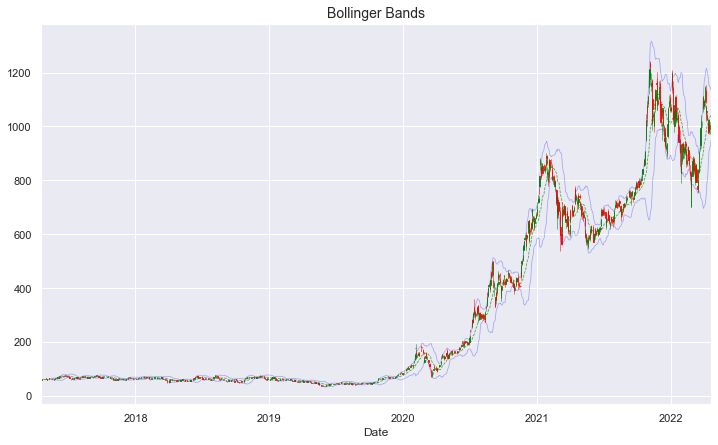

In [25]:
bollinger(df_tsla)

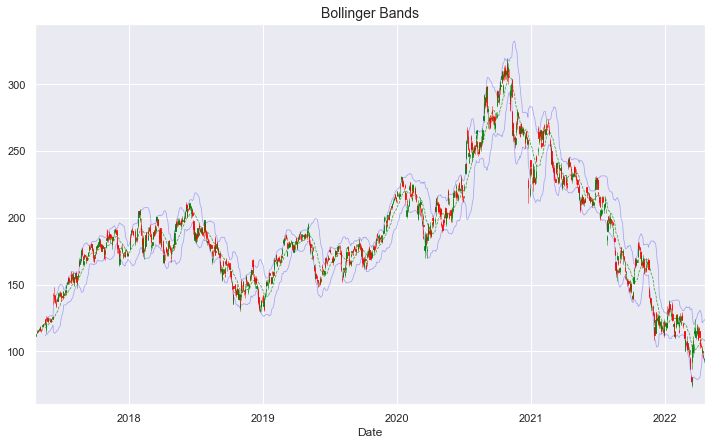

In [26]:
bollinger(df_baba)

### Correlation Plots <a class="anchor" id="Correlation_Plots"></a>

The correlation between stocks shows us the relationship that exists between two or more assets and how the change in their
value portrays this relationship. In investing having stocks that have low correlation values is an excellent way to diversify your portfolio. Below a correlation matrix and heatmap have been created to show a visual representation of how the stocks picked correlate to one another.

In [27]:
def cor_plot(*args):

    df_concat = pd.concat(args, axis=0)
    df_concat = df_concat.reset_index()
    
    df_concat = df_concat[['Date', 'Close', 'Symbol']]
    df_pivot=df_concat.pivot('Date','Symbol','Close').reset_index()
  
    corr_df = df_pivot.corr(method='pearson')
    corr_df.reset_index()
    
    plt.figure(figsize=(13, 8))
    sns.heatmap(corr_df, annot=True, cmap="Blues")
    plt.figure()

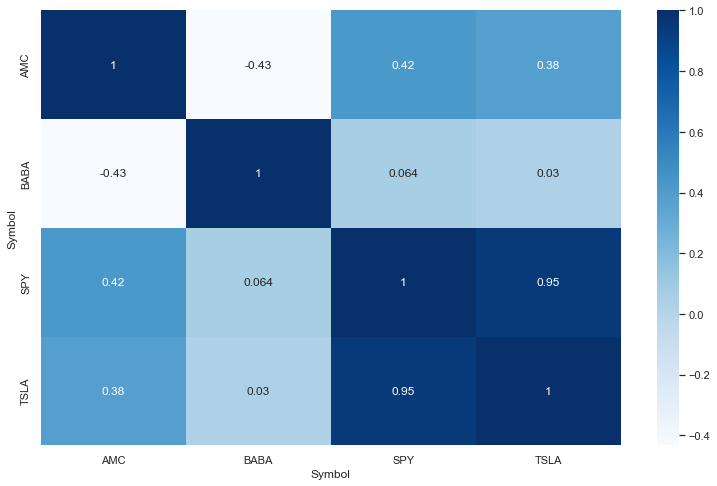

<Figure size 432x288 with 0 Axes>

In [28]:
cor_plot(df_spy, df_baba, df_amc, df_tsla)

## Conclusion <a class="anchor" id="Conclusion"></a>

The goal of this project was to setup a data pipeline and process some data. Initially we collected this data via YH Finances
API, stored the data in our AWS MYSQL database, retrieved that data, and did a small workflow consisting of a few common financial indicators. The path chosen to retrieve data was chosen to explore the use of API's in general and working with a cloud based server. There are several other plotting options out there, the methods I employed here were purely to reinforce some of the material I am currently studying. In financial analysis there are hundreds of indicators used to evaluate stocks, this small study has only scratched the surface.

In [ ]:
assert False, "breakpoint"